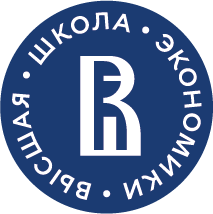

<hr> 

# PROJECT 

## Theme: Creating a model for predicting the gender of a subscriber of a Vkontakte social network group using VK API and machine learning algorithms


<hr> 

### Authors: 
- Rakhimkulova Aliya БАСБ212
- Turakulov Akramjon БАСБ212
- Petr Yakovlev БАСБ212

### Description

Our project is aimed at parsing VK group using created bot and using VK API, checking various hypotheses and training the Decision Tree model for gender prediction. The most important side of our project is working with real and big amount data

<hr>

We gonna work with the biggest student group of Higher school of economics - [хайер скул оф мемс](https://vk.com/hsemem). As we see the number of subscribers nearly 77.000

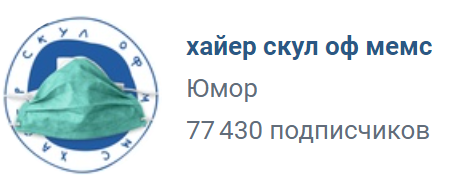

First of all we have to create a bot using VK API and configure it
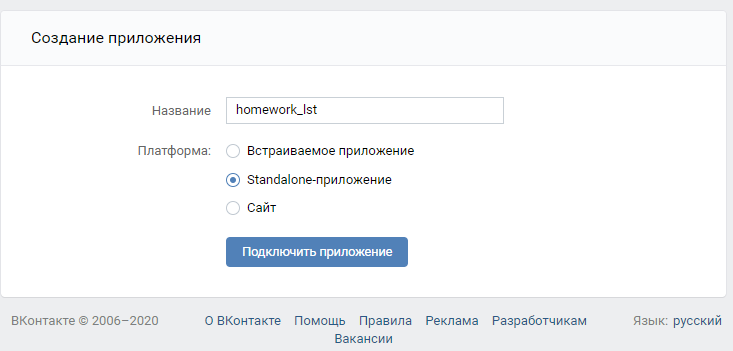

Using developer tools we find the unique identifier of the group that we will parse

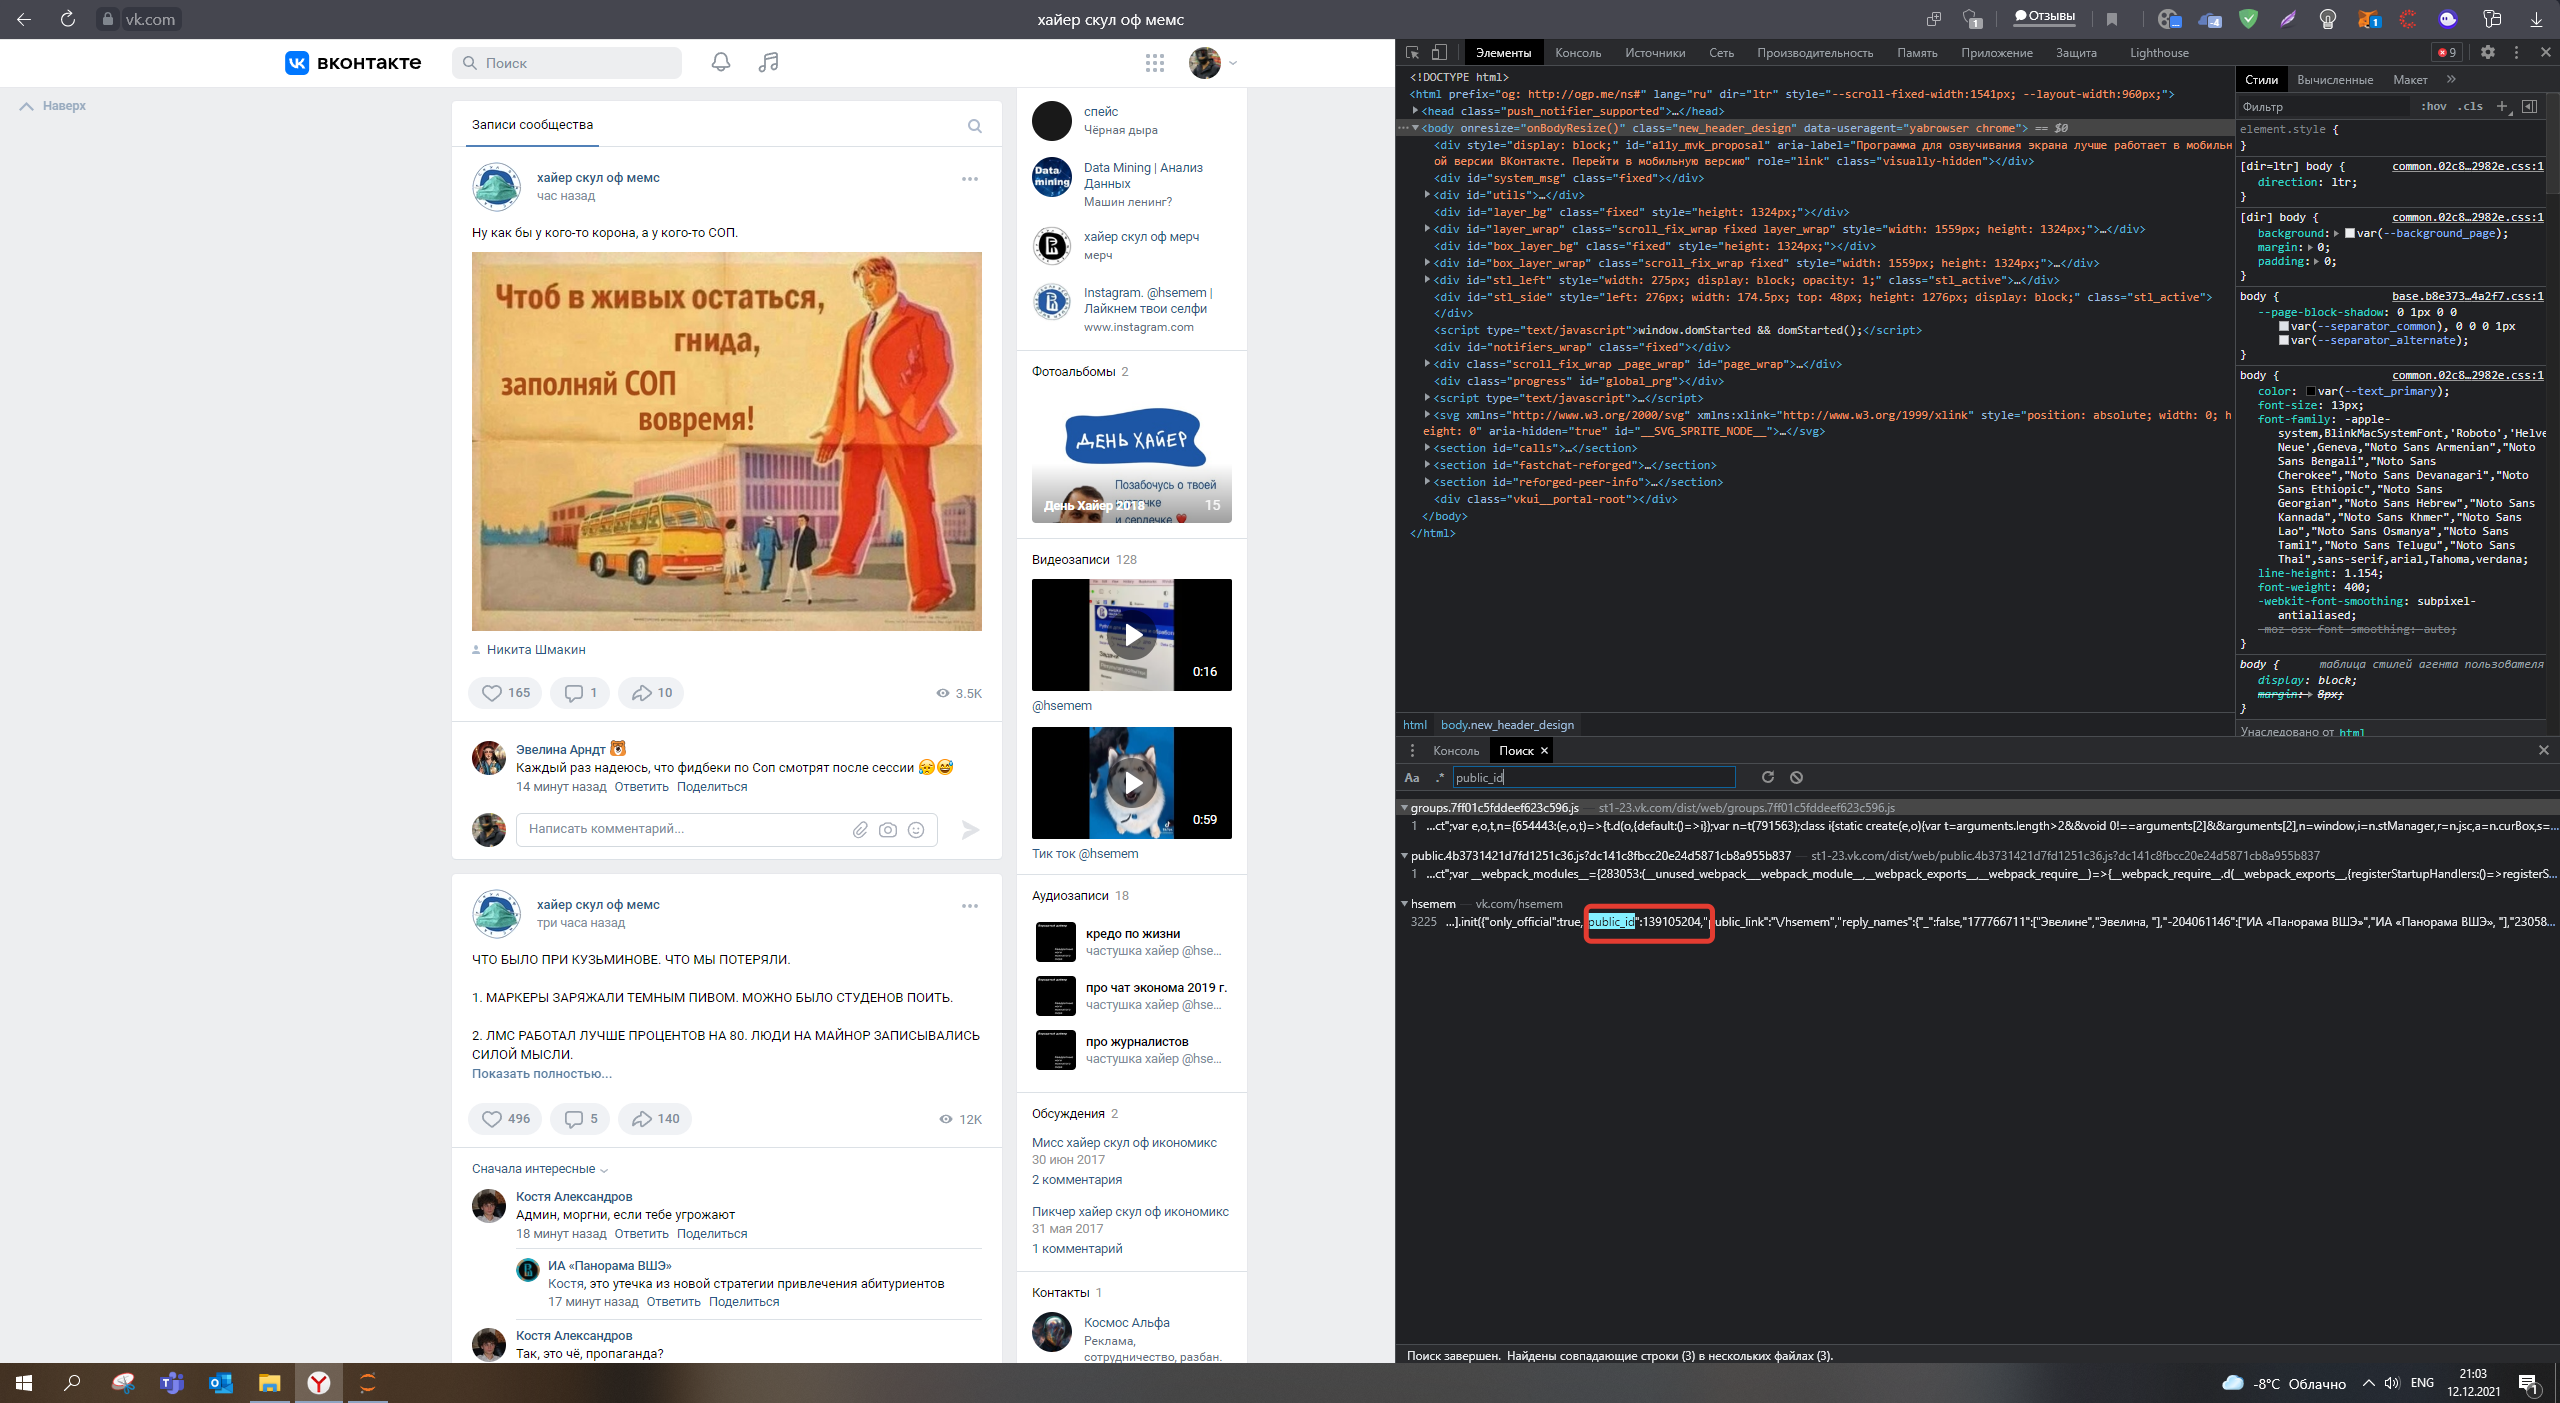

As we can see, the `public_id` of the group "хайер скул оф мемс" is equal to __139105204__

Importing modules

In [1]:
import pandas as pd
import numpy as np

import datetime as dt
import time

import requests
import re

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

We will store the token from the created bot locally in a text file for security reasons

### VK parsing

In [2]:
with open('token.txt') as f:
    token = f.read().strip()
version = '5.103'

The following unique identifier belongs to the group "хайер скул оф мемс"

In [3]:
group_id = '139105204'

In [4]:
def vk_download(method,parameters):
    time.sleep(1)
    url='https://api.vk.com/method/'+ method + '?'  + parameters +'&v=' + version + '&access_token=' + token
    response = requests.get(url)
    info = response.json()
    return info

We will write functions for parsing depending on different cases

In [5]:
def string_info_parse(array, string):
    for item in group['items']:
        try:
            array.append(str(item[string]))
        except:
            array.append(np.nan)
            
def int_info_parse(array, string):
    for item in group['items']:
        try:
            array.append(int(item[string]))
        except:
            array.append(np.nan)

def string_subinfo_parse(array, string, substring):
    for item in group['items']:
        try:
            array.append(str(item[string][substring]))
        except:
            array.append(np.nan)
                        
            
def int_subinfo_parse(array, string, substring):
    for item in group['items']:
        try:
            array.append(int(item[string][substring]))
        except:
            array.append(np.nan)
            
def string_subinfo2_parse(array, string, substring):
    for item in group['items']:
        try:
            array.append(str(item[string][0][substring]))
        except:
            array.append(np.nan)  
            
def int_subinfo_user(array, string, substring):
    for item in users:
        try:
            array.append(int(item[string][substring]))
        except:
            array.append(0)

Create arrays to store values

In [6]:
usr_id = []
first_name = []
last_name = []
bd = []
sex = []
is_closed = []
deactivated = []
followers_count = []
city = []
country = []
has_photo = []
has_mobile = []
universities = []
status = []
quotes = []
instagram = []
skype = []
twitter = []
political = []
smoking = []
alcohol = []
relation = []

We will parse data of approximately 77 thousand users. VK API has a significant limitation - the impossibility of parsing more than 1 thousand lines, so we create a loop.

In [7]:
%% time

for i in range(0, 78):
    offset = str(i*1000)
    group = vk_download('groups.getMembers', f'group_id={group_id}&fields=id,bdate,is_closed,followers_count,verified,sex,city,country,home_town,counters,connections,has_photo,has_mobile,universities,status,quotes,personal&offset={offset}')
    group = group["response"]
    
    int_info_parse(usr_id, 'id')
    string_info_parse(first_name, 'first_name')
    string_info_parse(last_name, 'last_name')
    string_info_parse(bd, 'bdate')
    int_info_parse(sex, 'sex')
    int_info_parse(is_closed, 'is_closed')
    string_info_parse(deactivated, 'deactivated')
    int_info_parse(followers_count, 'followers_count')
    string_subinfo_parse(city, 'city', 'title')
    string_subinfo_parse(country, 'country', 'title')
    int_info_parse(has_photo, 'has_photo')
    int_info_parse(has_mobile, 'has_mobile')
    string_subinfo2_parse(universities, 'universities', 'name')
    string_info_parse(status, 'status')
    string_info_parse(quotes, 'quotes')
    string_info_parse(instagram, 'instagram')
    string_info_parse(skype, 'skype')
    string_info_parse(twitter, 'twitter')
    string_subinfo_parse(political, 'personal', 'political')
    int_subinfo_parse(smoking, 'personal', 'smoking')
    int_subinfo_parse(alcohol, 'personal', 'alcohol')
    int_info_parse(relation, 'relation')


Replace the quotes with the length of the quotes, the same with the status

Replace the name of the instagram profile with the presence, that is, 0 and 1

In [8]:
for i in range(len(bd)):
    pattern = re.compile(r'\.\d{4}')
    if pattern.findall(str(bd[i])):
        continue
    else:
        bd[i] = np.nan

for i in range(len(status)):
    if status[i] is not np.nan:
        status[i] = len(status[i])
    else:
        status[i] = 0
    
    if quotes[i] is not np.nan:
        quotes[i] = len(quotes[i])
    else:
        quotes[i] = 0
      
    if instagram[i] is not np.nan:
        instagram[i] = 1
    else:
        instagram[i] = 0
        
    if skype[i] is not np.nan:
        skype[i] = 1
    else:
        skype[i] = 0   
    
    if twitter[i] is not np.nan:
        twitter[i] = 1
    else:
        twitter[i] = 0  

In [9]:
len(usr_id)

77431

In [10]:
df = pd.DataFrame(columns=['id','first_name','last_name','bdate','sex',
                           'is_closed','deactivated','followers_count',
                           'city','country','has_photo','has_mobile',
                           'universities','status','quotes','instagram',
                           'skype','twitter','political','smoking','alcohol',
                           'albums','videos','audios','posts','gifts','pages'], index = range(78000)) 

df['id'] = pd.Series(usr_id)
df['first_name'] = pd.Series(first_name)
df['last_name'] = pd.Series(last_name)
df['bdate'] = pd.Series(bd)
df['sex'] = pd.Series(sex)
df['is_closed'] = pd.Series(is_closed)
df['deactivated'] = pd.Series(deactivated)
df['followers_count'] = pd.Series(followers_count)
df['city'] = pd.Series(city)
df['country'] = pd.Series(country)
df['has_photo'] = pd.Series(has_photo)
df['has_mobile'] = pd.Series(has_mobile)
df['universities'] = pd.Series(universities)
df['status'] = pd.Series(status)
df['quotes'] = pd.Series(quotes)
df['instagram'] = pd.Series(instagram)
df['skype'] = pd.Series(skype)
df['twitter'] = pd.Series(twitter)
df['political'] = pd.Series(political)
df['smoking'] = pd.Series(smoking)
df['alcohol'] = pd.Series(alcohol)

df

,id,first_name,last_name,bdate,sex,is_closed,deactivated,followers_count,city,country,...,twitter,political,smoking,alcohol,albums,videos,audios,posts,gifts,pages
0,1257.0,Oleg,Urzhumtsev,19.10.1989,2.0,0.0,NaN,1494.0,Moscow,Russia,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1389.0,Ivan,Bezborody,24.12.1986,2.0,1.0,NaN,NaN,Nizhny Novgorod,Russia,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2050.0,Katya,Lebedeva,NaN,1.0,0.0,NaN,12548.0,Saint Petersburg,Russia,...,1.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,4913.0,Marina,Sekacheva,5.2.1984,1.0,1.0,NaN,NaN,Saint Petersburg,Russia,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6559.0,Fyodor,Klimenko,13.1.1984,2.0,0.0,NaN,3139.0,Barnaul,Russia,...,1.0,NaN,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
77996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
77997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
77998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We delete those lines in the `bdate` attribute in which there are omissions. The omissions in quantitative signs will be filled with zeros, and the omissions in categorical ones will be filled with the word `None`

In [11]:
df.dropna(subset=['bdate'], inplace = True)
df.dropna(subset=['followers_count'], inplace = True)
df.reset_index(drop=True, inplace = True)

df_num = df.select_dtypes(include = [np.float])
df[list(df_num.columns)] = df[list(df_num.columns)].fillna(0).astype(int)

df['political'] = df['political'].fillna(0).astype(int)

df_cat = df.select_dtypes(include = [np.object])
df[list(df_cat.columns)] = df[list(df_cat.columns)].fillna('None')

Since VK API does not allow to parse user information by immediately throwing an array of user id's, we will have to parse them separately

In [12]:
df.drop(df[df.sex == 0].index, inplace = True)
df

,id,first_name,last_name,bdate,sex,is_closed,deactivated,followers_count,city,country,...,twitter,political,smoking,alcohol,albums,videos,audios,posts,gifts,pages
0,1257,Oleg,Urzhumtsev,19.10.1989,2,0,None,1494,Moscow,Russia,...,1,0,0,0,None,None,None,None,None,None
1,6559,Fyodor,Klimenko,13.1.1984,2,0,None,3139,Barnaul,Russia,...,1,0,1,2,None,None,None,None,None,None
2,8612,Anastasia,Obolenskaya,1.4.1996,1,0,None,14456,Phuket,Thailand,...,0,0,0,0,None,None,None,None,None,None
3,10904,Nikita,Vul,6.9.1978,2,0,None,448,Saint Petersburg,Russia,...,0,0,0,0,None,None,None,None,None,None
4,43668,Ekaterina,Agafonova,14.7.1985,1,0,None,600,Saint Petersburg,Russia,...,0,0,0,0,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20654,692801380,Varvara,Trafimova,6.10.2002,1,0,None,2,None,None,...,0,0,0,0,None,None,None,None,None,None
20655,693002490,Alexandra,Sobol,23.8.2002,1,0,None,2,Rubtsovsk,Russia,...,0,0,0,0,None,None,None,None,None,None
20656,693043680,Ilya,Kamov,23.9.2003,2,0,None,2,Sevastopol,Russia,...,0,0,0,0,None,None,None,None,None,None
20657,693108853,Wanda,Jkvskdvhsb,17.1.1999,1,0,None,0,None,None,...,0,0,0,0,None,None,None,None,None,None


In [13]:
ids = df.id.to_numpy()

albums = []
videos = []
audios = []
posts = []
gifts = []
pages = []

This block of code runs for 2 hours because of huge amount of parsing data

In [14]:
%% time

for i in ids:
    url=f'https://api.vk.com/method/users.get?user_ids={i}&fields=id,bdate,counters&v=' + version + '&access_token=' + token
    response = requests.get(url)
    users = response.json()
    users = users["response"]
    time.sleep(0.09)

    int_subinfo_user(albums, 'counters', 'albums')
    int_subinfo_user(videos, 'counters', 'videos')
    int_subinfo_user(audios, 'counters', 'audios')
    int_subinfo_user(posts, 'counters', 'posts')
    int_subinfo_user(gifts, 'counters', 'gifts')
    int_subinfo_user(pages, 'counters', 'pages')

In [15]:
df['albums'] = pd.Series(albums)
df['videos'] = pd.Series(videos)
df['audios'] = pd.Series(audios)
df['posts'] = pd.Series(posts)
df['gifts'] = pd.Series(gifts)
df['pages'] = pd.Series(pages)
df

,id,first_name,last_name,bdate,sex,is_closed,deactivated,followers_count,city,country,...,twitter,political,smoking,alcohol,albums,videos,audios,posts,gifts,pages
0,1257,Oleg,Urzhumtsev,19.10.1989,2,0,None,1494,Moscow,Russia,...,1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,6559,Fyodor,Klimenko,13.1.1984,2,0,None,3139,Barnaul,Russia,...,1,0,1,2,NaN,NaN,NaN,NaN,NaN,NaN
2,8612,Anastasia,Obolenskaya,1.4.1996,1,0,None,14456,Phuket,Thailand,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,10904,Nikita,Vul,6.9.1978,2,0,None,448,Saint Petersburg,Russia,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,43668,Ekaterina,Agafonova,14.7.1985,1,0,None,600,Saint Petersburg,Russia,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20654,692801380,Varvara,Trafimova,6.10.2002,1,0,None,2,None,None,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
20655,693002490,Alexandra,Sobol,23.8.2002,1,0,None,2,Rubtsovsk,Russia,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
20656,693043680,Ilya,Kamov,23.9.2003,2,0,None,2,Sevastopol,Russia,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
20657,693108853,Wanda,Jkvskdvhsb,17.1.1999,1,0,None,0,None,None,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


Here we saved our dataset in order to not wait several hours for parsing when we rerun script

In [18]:
# df.to_csv('hse.csv', index = False)

In [17]:
# df = pd.read_csv('hse.csv')
# df

In [19]:
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Misses', 1 : '% from all data'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% from all data', ascending=False).round(1)
        print ("Dataframe contains " + str(df.shape[1]) + " columns.\n"      
            "Overall " + str(mis_val_table_ren_columns.shape[0]) +
              " columns with missing values.")
        return mis_val_table_ren_columns
missing_values_table(df).style.background_gradient(cmap='Reds')

Dataframe contains 27 columns.
Overall 6 columns with missing values.


,Misses,% from all data
albums,5,0.000000
videos,5,0.000000
audios,5,0.000000
posts,5,0.000000
gifts,5,0.000000
pages,5,0.000000


In [20]:
df = df.fillna(0)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20642 entries, 0 to 20641
Data columns (total 27 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               20642 non-null  int64  
 1   first_name       20642 non-null  object 
 2   last_name        20642 non-null  object 
 3   bdate            20642 non-null  object 
 4   sex              20642 non-null  int64  
 5   is_closed        20642 non-null  int64  
 6   deactivated      20642 non-null  object 
 7   followers_count  20642 non-null  int64  
 8   city             20642 non-null  object 
 9   country          20642 non-null  object 
 10  has_photo        20642 non-null  int64  
 11  has_mobile       20642 non-null  int64  
 12  universities     20642 non-null  object 
 13  status           20642 non-null  int64  
 14  quotes           20642 non-null  int64  
 15  instagram        20642 non-null  int64  
 16  skype            20642 non-null  int64  
 17  twitter     

Let me remind you, in the `sex` column, women take the value 1, and men 2.  
For clarity, replace the values with string values

In [22]:
df.sex.value_counts()

1    11666
2     8976
Name: sex, dtype: int64

In [23]:
df.sex[df['sex'] == 1] = 'female'
df.sex[df['sex'] == 2] = 'male'
df.sex.value_counts()

female    11666
male       8976
Name: sex, dtype: int64

Let's translate the `bdate` attribute to the date type

In [24]:
df["bdate"] = df["bdate"].astype("datetime64")
df.head()

,id,first_name,last_name,bdate,sex,is_closed,deactivated,followers_count,city,country,...,twitter,political,smoking,alcohol,albums,videos,audios,posts,gifts,pages
0,1257,Oleg,Urzhumtsev,1989-10-19,male,0,None,1495,Moscow,Russia,...,1,0,0,0,28.0,39.0,459.0,0.0,47.0,32.0
1,6559,Fyodor,Klimenko,1984-01-13,male,0,None,3138,Barnaul,Russia,...,1,0,1,2,7.0,246.0,788.0,0.0,0.0,654.0
2,8612,Anastasia,Obolenskaya,1996-01-04,female,0,None,14447,Phuket,Thailand,...,0,0,0,0,0.0,0.0,0.0,0.0,18.0,1765.0
3,10904,Nikita,Vul,1978-06-09,male,0,None,448,Saint Petersburg,Russia,...,0,0,0,0,0.0,119.0,90.0,0.0,8.0,91.0
4,43668,Ekaterina,Agafonova,1985-07-14,female,0,None,598,Saint Petersburg,Russia,...,0,0,0,0,0.0,25.0,45.0,0.0,0.0,369.0


### Feature engineering

__Let's create a new attribute. Birth on any of the official non-working days in the Russian Federation, that is, holidays, etc.__

The value of $1$ means a birth on a holiday, the value of $0$ on a regular day

The list is taken from the website [консультант плюс](http://www.consultant.ru/document/cons_doc_LAW_34683/98ef2900507766e70ff29c0b9d8e2353ea80a1cf/)

* 1, 2, 3, 4, 5, 6 and January 8 - New Year holidays;
* January 7 - Christmas;
* February 23 - Defender of the Fatherland Day;
* March 8 - International Women's Day;
* May 1 - Spring and Labor Day;
* May 9 - Victory Day;
* June 12 - Russia Day;
* November 4 - National Unity Day.

In [25]:
df['holiday'] = 0
holidays = np.arange(1,9)
for day_num in holidays:
    df.holiday[df[(df["bdate"].dt.month == 1) & (df["bdate"].dt.day == day_num)].index] = 1
    
df.holiday[df[(df["bdate"].dt.month == 2) & (df["bdate"].dt.day == 23)].index] = 1
df.holiday[df[(df["bdate"].dt.month == 3) & (df["bdate"].dt.day == 8)].index] = 1
df.holiday[df[(df["bdate"].dt.month == 5) & (df["bdate"].dt.day == 1)].index] = 1
df.holiday[df[(df["bdate"].dt.month == 5) & (df["bdate"].dt.day == 9)].index] = 1
df.holiday[df[(df["bdate"].dt.month == 6) & (df["bdate"].dt.day == 12)].index] = 1
df.holiday[df[(df["bdate"].dt.month == 11) & (df["bdate"].dt.day == 4)].index] = 1

In [26]:
df.head()

,id,first_name,last_name,bdate,sex,is_closed,deactivated,followers_count,city,country,...,political,smoking,alcohol,albums,videos,audios,posts,gifts,pages,holiday
0,1257,Oleg,Urzhumtsev,1989-10-19,male,0,None,1495,Moscow,Russia,...,0,0,0,28.0,39.0,459.0,0.0,47.0,32.0,0
1,6559,Fyodor,Klimenko,1984-01-13,male,0,None,3138,Barnaul,Russia,...,0,1,2,7.0,246.0,788.0,0.0,0.0,654.0,0
2,8612,Anastasia,Obolenskaya,1996-01-04,female,0,None,14447,Phuket,Thailand,...,0,0,0,0.0,0.0,0.0,0.0,18.0,1765.0,1
3,10904,Nikita,Vul,1978-06-09,male,0,None,448,Saint Petersburg,Russia,...,0,0,0,0.0,119.0,90.0,0.0,8.0,91.0,0
4,43668,Ekaterina,Agafonova,1985-07-14,female,0,None,598,Saint Petersburg,Russia,...,0,0,0,0.0,25.0,45.0,0.0,0.0,369.0,0


### Hypothesis checking

#### Check the hypothesis that women tend to be born on holidays more than men

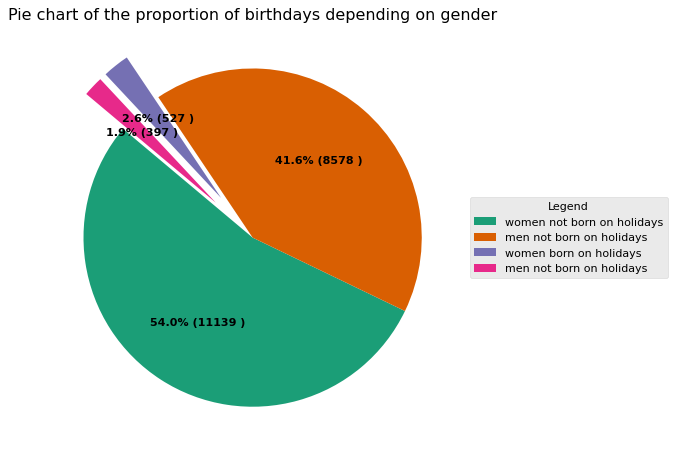

In [27]:
df_raw = df.groupby(['holiday','sex'])['id'].count().reset_index(name='counts')
fig, ax = plt.subplots(figsize=(12, 7), subplot_kw=dict(aspect="equal"), dpi= 80)

data = df_raw['counts']
categories = ['women not born on holidays', 
                'men not born on holidays',
                'women born on holidays',
                'men not born on holidays']
explode = [0,0,0.3,0.3]

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}% ({:d} )".format(pct, absolute)

wedges, texts, autotexts = ax.pie(data, 
                                  autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="black"), 
                                  colors=plt.cm.Dark2.colors,
                                  startangle=140,
                                  explode=explode)

# Decoration
ax.legend(wedges, categories, title="Legend", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.setp(autotexts, size=10, weight=700)
ax.set_title("Pie chart of the proportion of birthdays depending on gender")
plt.show()

__ANSWER: Women tend to be born on holidays more than girls. But it's worth noting that there are different numbers of men and women in our sample, so it's impossible to say for sure__

#### Check the hypothesis that says that most of the subscribers of the public are people over 40 years old

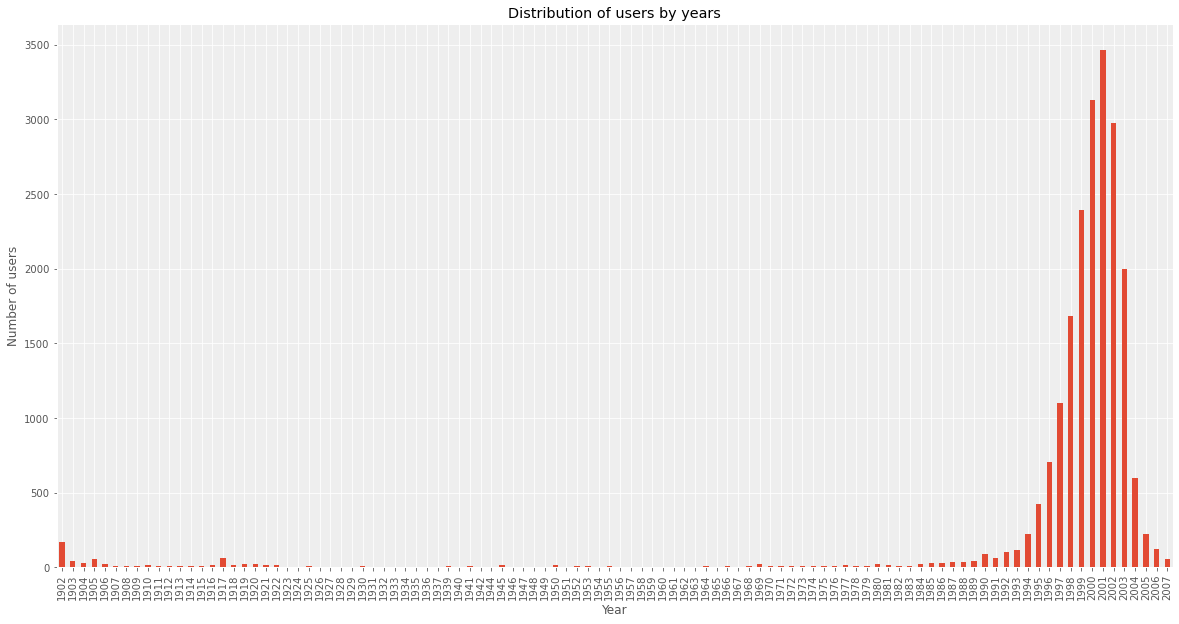

In [35]:
plt.figure(figsize=(20, 10))
df['year'] = df["bdate"].dt.year
ax = (df.groupby('year')['id'].count()).plot(kind="bar")
ax.set_facecolor('#eeeeee')
ax.set_xlabel("Year")
ax.set_ylabel("Number of users")
ax.set_title('Distribution of users by years')
plt.show()

In [36]:
df['year'].median()

2000.0

__ANSWER: The graph shows that the majority of subscribers are people born in 1996-2003. Consequently, most of the subscribers of the public are people from 18 to 25 years old__

#### Check the hypothesis that girls post more often than guys

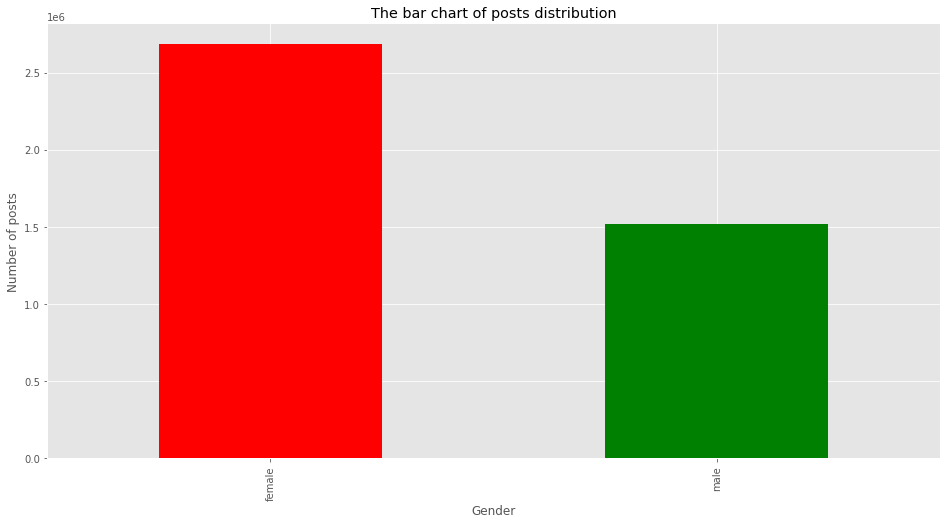

In [37]:
plt.rcParams['figure.figsize'] = (16, 8)
color_list = ['r', 'g']
ax = df.loc[:, ['followers_count', 'sex']].fillna(0).groupby('sex')['followers_count'].sum().plot(kind='bar', color=color_list)
ax.set_xlabel("Gender")
ax.set_ylabel("Number of posts")
ax.set_title('The bar chart of posts distribution');

__ANSWER: As the diagram shows, girls post publications on their page more often than boys.__

#### Check the hypothesis that girls most often indicate the presence of an Instagram profile

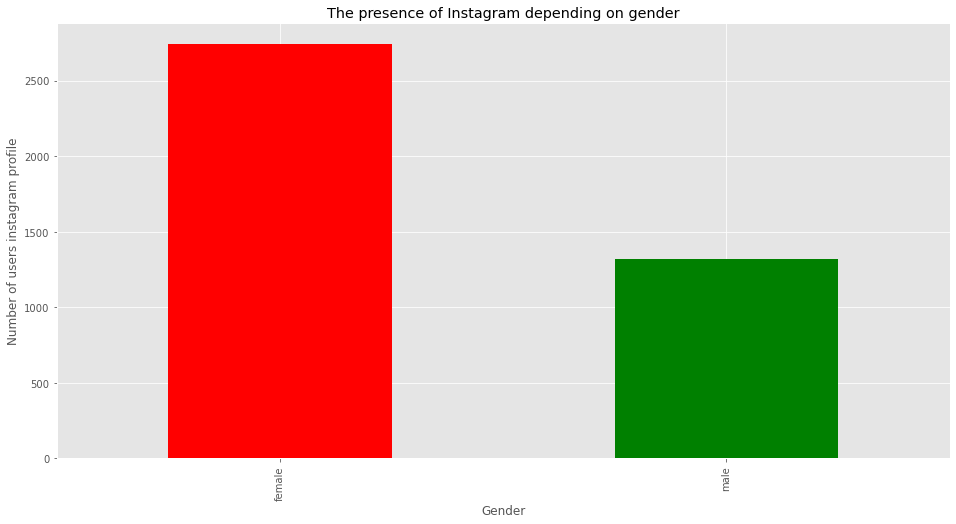

In [39]:
plt.rcParams['figure.figsize'] = (16, 8)
ax = df.loc[:, ['instagram', 'sex']].fillna(0).groupby('sex')['instagram'].sum().plot(kind='bar', color=color_list)
ax.set_xlabel("Gender")
ax.set_ylabel("Number of users instagram profile")
ax.set_title('The presence of Instagram depending on gender');

__ANSWER: The hypothesis is correct, as the diagram shows, most often the presence of an Instagram profile is indicated by girls__

As we can see our dataset is quite consistent and can be used for model building

### Correlation analysis

Let's build a correlation matrix

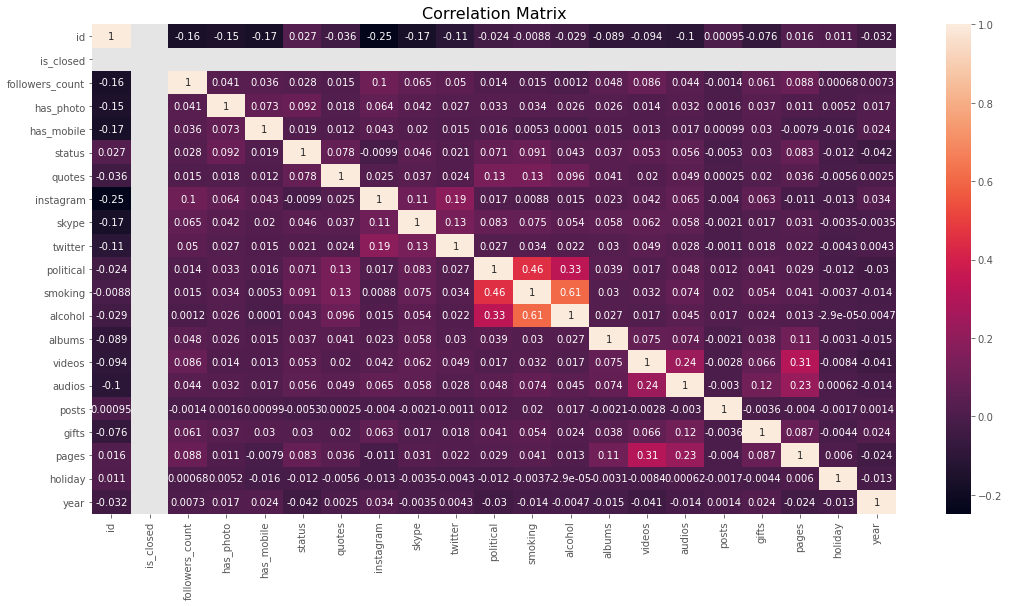

In [40]:
plt.figure(figsize=(18,9))
plt.title('Correlation Matrix', fontsize=16)
sns.heatmap(df.corr(), annot=True)
plt.show()

Let's make quantitative variables out of categorical variables. To do this, we apply `LabelEncoder()`

In [41]:
objects = ['universities','country','city','deactivated','last_name','first_name','bdate']
df_new = df
label_encoders = {}
for col in objects:
    label_encoders[col] = LabelEncoder()
    df_new[col] = label_encoders[col].fit_transform(df_new[col])

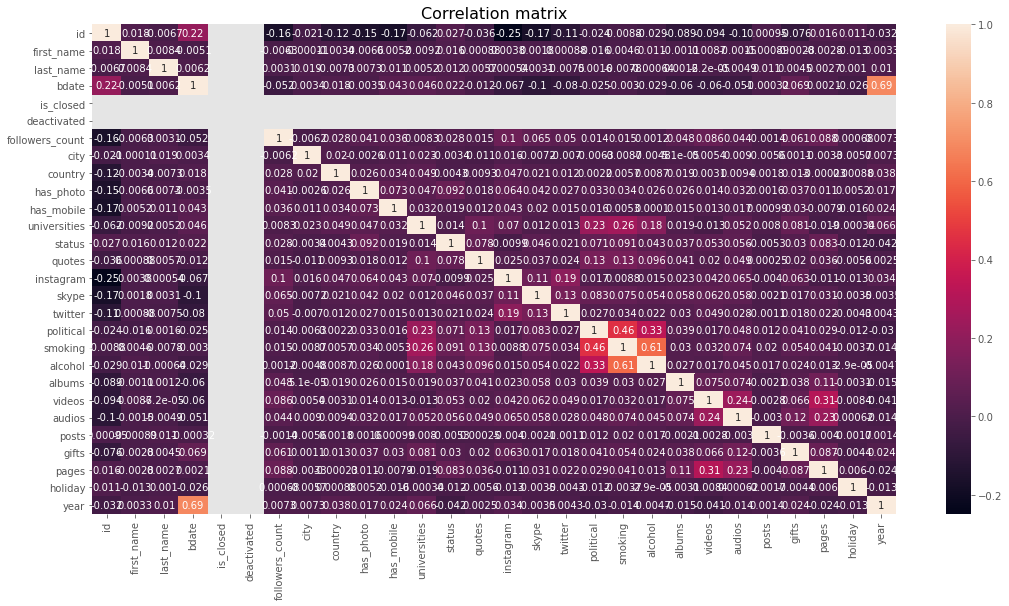

In [42]:
plt.figure(figsize=(18,9))
plt.title('Correlation matrix', fontsize=16)
sns.heatmap(df_new.corr(), annot=True)
plt.show()

In [43]:
y = df_new['sex'].replace({'male':1, 'female':0})
df_new = df_new.drop('sex', axis = 1)

### Decision tree model building

In [44]:
X_train, X_test, y_train, y_test = train_test_split(df_new, y, test_size = 0.3, random_state = 42)

Roc-Auc (Val): 0.8101691937637088
Gini (Val) : 0.6203383875274175
Classification report: 
               precision    recall  f1-score   support

           0       0.83      0.84      0.83      3462
           1       0.79      0.78      0.79      2731

    accuracy                           0.81      6193
   macro avg       0.81      0.81      0.81      6193
weighted avg       0.81      0.81      0.81      6193

Confusion matrix: 
 [[2893  569]
 [ 588 2143]]


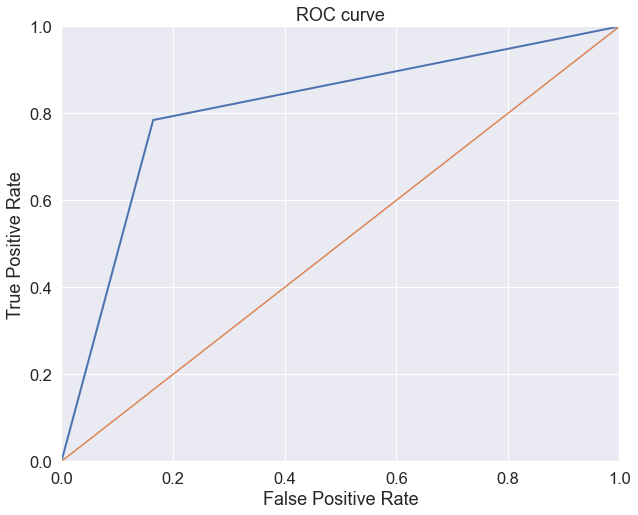

In [45]:
DT = DecisionTreeClassifier()
DT.fit(X_train,y_train)

preds_dev = DT.predict(X_train)
preds_val = DT.predict(X_test)

print('Roc-Auc (Val):', roc_auc_score(y_test, preds_val))
print('Gini (Val) :', 2*roc_auc_score(y_test, preds_val)-1)
print('Classification report: \n', classification_report(y_test, preds_val))
print('Confusion matrix: \n', confusion_matrix(y_test, preds_val))

#Display ROC-AUC graph
sns.set(font_scale=1.5)
sns.set_color_codes("muted")
plt.figure(figsize=(10, 8))

fpr, tpr, thresholds = roc_curve(y_test, preds_val)
roc_auc  = auc(fpr, tpr)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

Classificattion metrics interpretation

- $accuracy = \frac{TP+TN}{TP+TN+FP+FN}$ - shows the percentage of correct system responses;
- $precision = \frac{TP}{TP+FP}$ - shows the accuracy of the system's prediction (if the algorithm said that the person is male, how much can it be trusted);
- $recall = \frac{TP}{TP+FN}$ - shows the completeness of the system's responses (how many males it will find from all the data presented).

The description of the confusion matrix is

|      | y=1  | y=0 |
|------|------|-----|
| y'=1 | True Positive (TP) | False Positive (FP) |
| y'=0 | False Negative (FN) | True Negative (TN) |

Let's make an interpretation of the elements
* True Positive: You predicted positive and it’s true.
* True Negative: You predicted negative and it’s true.
* False Positive (Type 1 Error): You predicted positive and it’s false.
* False Negative (Type 2 Error): You predicted negative and it’s false.

Decision tree model confusion matrix interpretation:

True Positive stands for correct predicted `0` gender class while False Negative stand for incorrectly predicted `1` gender class as `0` class. True Negative stands for correct predicted `1` gender class while False Positive stand for incorrectly predicted `0` gender class as `1` class.

### Overall

We can see that our created model have quite strong predictive strength and can be used as good colution for such indusrties as social analysis and ads marketing